In [1]:
import operator
from os import getcwd, listdir, chdir

from PIL.Image import new
from cv2 import data
import cv2
chdir('../..')
from os.path import dirname, join
import numpy as np
from numpy.fft import fftshift, fft2
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from UltraCold import OD, NPS


In [2]:
# Modify this according to file position
baseDir = getcwd()
DATA_DIR = join(baseDir, 'DATA')


id: 051624, #img: 137


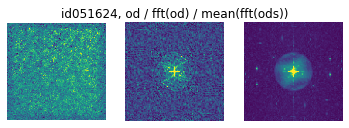

accept dataset 051624
id: 051649, #img: 110


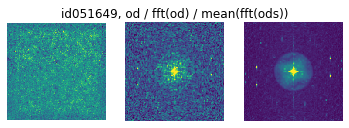

accept dataset 051649
id: 061426, #img: 0
id: 061427, #img: 0
id: 061554, #img: 53


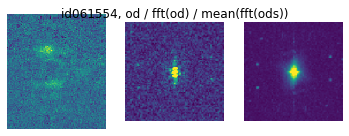

decline dataset 061554
id: 061606, #img: 10
id: 061606 skipped due to bad trap region
id: 131805, #img: 21
id131805 do not have square-like trap region. Reject.
id: 141001, #img: 21


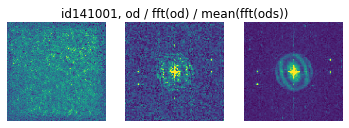

accept dataset 141001
id: 141147, #img: 25


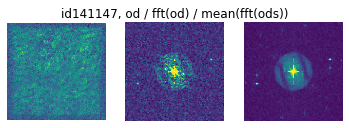

accept dataset 141147
id: 141153, #img: 22


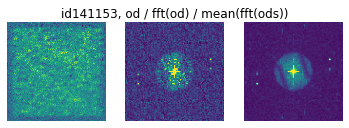

accept dataset 141153
id: 141201, #img: 21


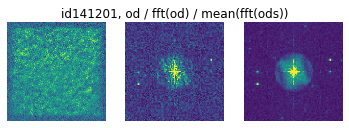

accept dataset 141201
id: 141206, #img: 21


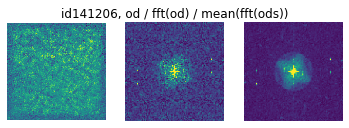

accept dataset 141206
id: 141218, #img: 23
id141218 do not have square-like trap region. Reject.
id: 141902, #img: 23


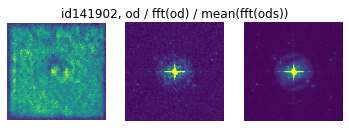

accept dataset 141902
id: 211412, #img: 126


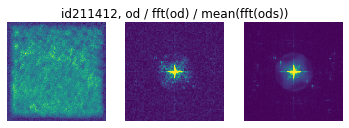

accept dataset 211412
id: 221529, #img: 21


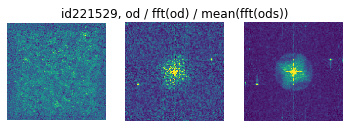

accept dataset 221529
COMPLETE
we have 527 images in total
included datesets: 051624,051649,141001,141147,141153,141201,141206,141902,211412,221529


In [3]:
src_list, tar_list = [], []
# mean_list = []
CUTOFF = 99.65
included_dataset = []


def odfft(od):
    return abs(fftshift(fft2(fftshift(od))))


def get_vmax(img, q):
    return np.percentile(img.flatten(), q)


for ods, dataset_id in OD.iter_through_dir(mode='group'):

    ods_fft = [odfft(od) for od in ods]
    odfftavg = np.mean(ods_fft, axis=0)
    # adjust the size to 128 * 128

    W, H = np.shape(odfftavg)
    if abs(W - H) / (W + H) > 0.1:
        print(f'id{dataset_id} do not have square-like trap region. Reject.')
        continue
    side = min(W, H)

    def cropND(img, bounding):
        start = tuple(map(lambda a, da: a // 2 - da // 2, img.shape, bounding))
        end = tuple(map(operator.add, start, bounding))
        slices = tuple(map(slice, start, end))
        return img[slices]

    def crop(img, side):
        img = cropND(img, (side, side))
        return cv2.resize(img, (128, 128), interpolation=cv2.INTER_LINEAR)

    ods_fft = [crop(img, side) for img in ods_fft]
    odfftavg = crop(odfftavg, side)

    # map the clipped image to [-1,1]
    # standardization
    od_cutoff = sum(
        (get_vmax(od_fft, CUTOFF) for od_fft in ods_fft)) / len(ods)
    fftavg_cutoff = get_vmax(odfftavg, CUTOFF)
    new_src_list = [
        np.clip(od_fft * 2 / od_cutoff - 1, -1, 1) for od_fft in ods_fft
    ]
    new_tar_list = [np.clip(odfftavg * 2 / fftavg_cutoff - 1, -1, 1)
                    ] * len(ods_fft)

    img_iter = zip(ods, new_src_list, new_tar_list)
    while True:
        rawinput = input(
            'C = next image if possible, A = accept current dataset, D = decline current dataset, E = exit'
        )
        if rawinput == 'C' or rawinput == '':
            try:
                od, srcimg, tarimg = next(img_iter)
                # fig=plt.figure(figsize=(4,20),dpi=100)
                plt.subplot(1, 3, 1)
                plt.imshow(od)
                plt.axis('off')
                # plt.colorbar()
                plt.subplot(1, 3, 2)
                plt.imshow(srcimg)
                plt.title(f'id{dataset_id}, od / fft(od) / mean(fft(ods))')
                plt.axis('off')
                # plt.colorbar()
                plt.subplot(1, 3, 3)
                plt.imshow(tarimg)
                plt.axis('off')
                # plt.colorbar()
                plt.show()

            except StopIteration as e:
                print('no more image in this set')
        elif rawinput == 'A':
            src_list.extend(new_src_list)
            tar_list.extend(new_tar_list)
            included_dataset.append(dataset_id)
            print(f'accept dataset {dataset_id}')
            break
        elif rawinput == 'D':
            print(f'decline dataset {dataset_id}')
            break
        elif rawinput == 'E':
            raise KeyboardInterrupt()
print('COMPLETE')
print(f'we have {len(src_list)} images in total')
print(f'included datesets: {",".join(included_dataset)}')
